# DAP6 - Model Analysis

## Imports

In [7]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# d-tree features
from graphviz import Source
from sklearn.tree import export_graphviz

In [8]:
# show confusion matrix - written by dr bae
def plot_confusion_matrix(confusion_mat, cln):
    plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.gray)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(cln)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [9]:
# show most important features
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)

In [12]:
# grab data and split
df = pd.read_csv("../DAP2/processeddata/2018_Financial_Data.csv", index_col=0)
target_cols = ['priceCashFlowRatio', 
               'priceEarningsRatio', 
               'priceEarningsToGrowthRatio', 
               'priceBookValueRatio', 
               'currentRatio', 
               'quickRatio',
               'payoutRatio']
X = df[target_cols]
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# scale data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# create cv
kf = KFold(n_splits=10, random_state=None, shuffle=True) 

# Analysis

### Accuracies

In [14]:
# create dict of classifiers 
cls = {
    'KNN'        : KNeighborsClassifier(n_neighbors=15),
    'NB'         : GaussianNB(),
    'DT_entropy' : DecisionTreeClassifier(max_depth=2, criterion='entropy'),
    'DT_gini'    : DecisionTreeClassifier(max_depth=2, criterion='gini'),
    'NN1' : MLPClassifier(hidden_layer_sizes=[10], activation='tanh', alpha=0.01, random_state=0, max_iter=50000),
    'NN2' : MLPClassifier(hidden_layer_sizes=[10, 10], activation='relu', alpha=0.1, random_state=0, max_iter=50000)
}

In [27]:
for cl in cls:
    cls[cl].fit(X_train_scaled, y_train)    
    print(cl, ":")
    print("\tTrain accuracy: ", cls[cl].score(X_train_scaled, y_train))
    print("\tTest accuracy: ", cls[cl].score(X_test_scaled, y_test))

KNN :
	Train accuracy:  0.7729357798165137
	Test accuracy:  0.7652439024390244
NB :
	Train accuracy:  0.7347094801223242
	Test accuracy:  0.7317073170731707
DT_entropy :
	Train accuracy:  0.7675840978593272
	Test accuracy:  0.75
DT_gini :
	Train accuracy:  0.7668195718654435
	Test accuracy:  0.7591463414634146
NN1 :
	Train accuracy:  0.7477064220183486
	Test accuracy:  0.7682926829268293
NN2 :
	Train accuracy:  0.7530581039755352
	Test accuracy:  0.7652439024390244


### Confusion Matrices

KNN 
 [[ 21  57]
 [ 20 230]]


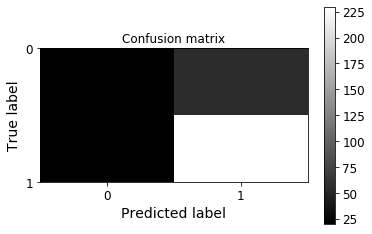

NB 
 [[ 27  51]
 [ 37 213]]


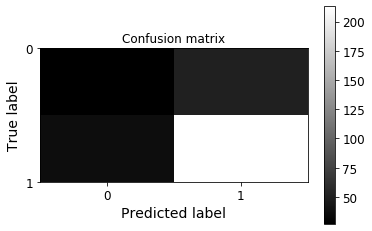

DT_entropy 
 [[  5  73]
 [  9 241]]


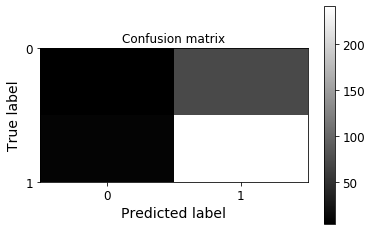

DT_gini 
 [[  5  73]
 [  6 244]]


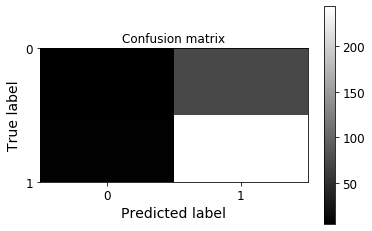

NN1 
 [[  3  75]
 [  1 249]]


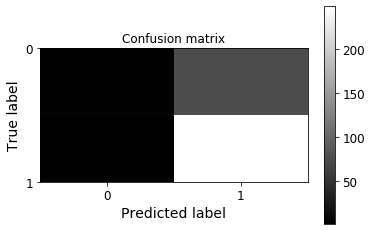

NN2 
 [[  3  75]
 [  2 248]]


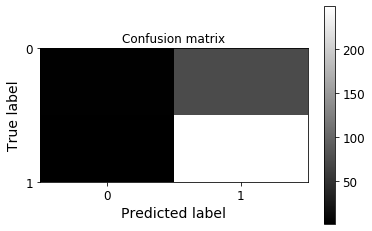

In [16]:
for cl in cls: 
    cls[cl].fit(X_train_scaled, y_train)
    y_pred = cls[cl].predict(X_test_scaled)

    # create and plot a confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)
    print(cl,'\n',confusion_mat)
    plot_confusion_matrix(confusion_mat, 2)

### ROC Curves

KNN Accuracy =  0.7188717948717949


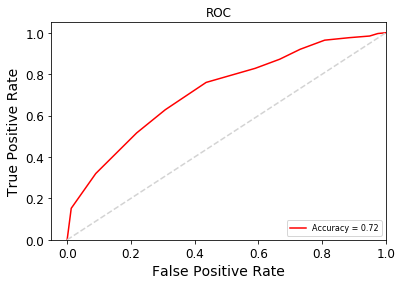

NB Accuracy =  0.7011282051282052


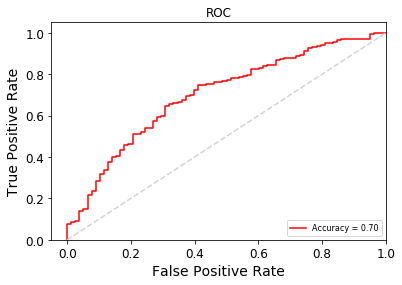

DT_entropy Accuracy =  0.6465641025641026


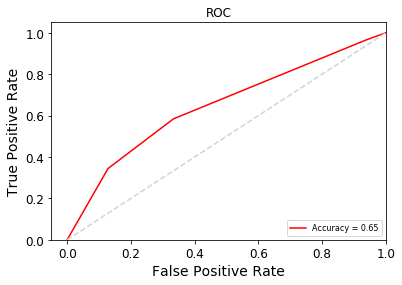

DT_gini Accuracy =  0.6761025641025641


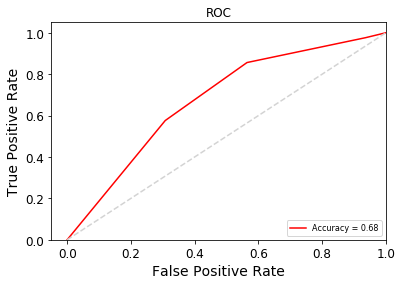

NN1 Accuracy =  0.683076923076923


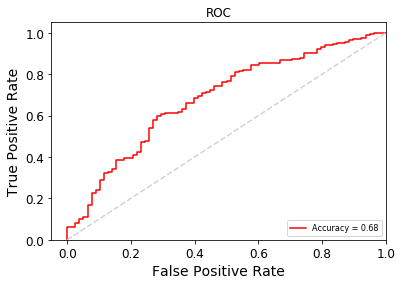

NN2 Accuracy =  0.6730256410256409


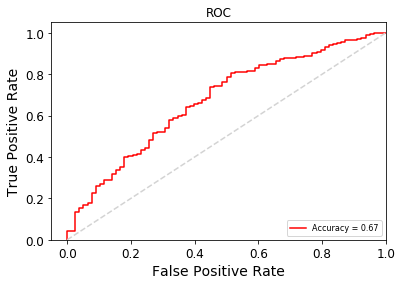

In [17]:
# roc curves 
for cl in cls: 
    y_pred = cls[cl].predict_proba(X_test_scaled)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred[:,1])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print(cl,'Accuracy = ', roc_auc)

    # Plotting
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate, c='r', label=('Accuracy = %0.2f'%roc_auc))
    plt.legend(loc='lower right', prop={'size':8})
    plt.plot([0,1],[0,1], color='lightgrey', linestyle='--')
    plt.xlim([-0.05,1.0])
    plt.ylim([0.0,1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Important Features

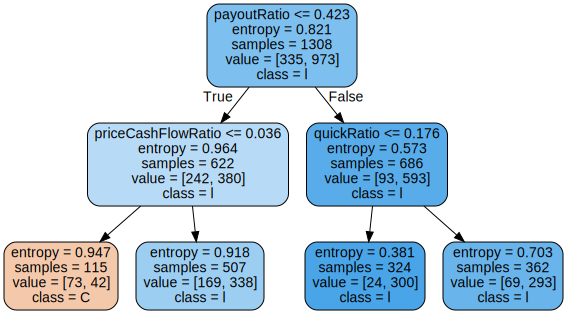

In [18]:
# decision trees important features (entropy)
export_graphviz(
        cls['DT_entropy'],
        out_file="entropy.dot",
        feature_names=target_cols,
        class_names='Class',
        rounded=True,
        filled=True
    )
Source.from_file("entropy.dot")

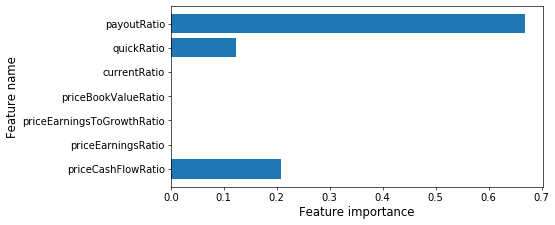

Feature importances: [0.20812567 0.         0.         0.         0.         0.1229966
 0.66887773]


In [19]:
# label important features
plt.figure(figsize=(8,4), dpi=60)
plot_feature_importances(cls['DT_entropy'], target_cols)
plt.show()
print('Feature importances: {}'.format(cls['DT_entropy'].feature_importances_))

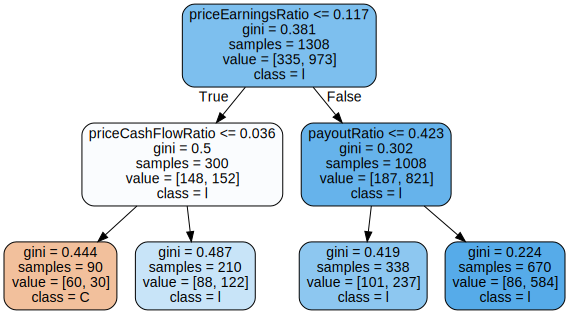

In [20]:
# decision trees important features (gini)
export_graphviz(
        cls['DT_gini'],
        out_file="gini.dot",
        feature_names=target_cols,
        class_names='Class',
        rounded=True,
        filled=True
    )
Source.from_file("gini.dot")

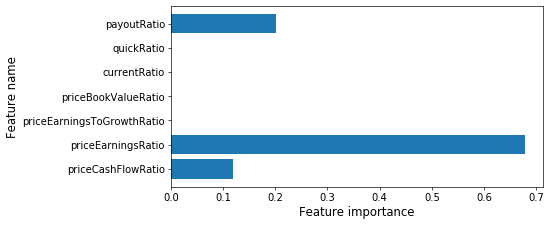

Feature importances: [0.11960591 0.67827302 0.         0.         0.         0.
 0.20212106]


In [21]:
# label important features
plt.figure(figsize=(8,4), dpi=60)
plot_feature_importances(cls['DT_gini'], target_cols)
plt.show()
print('Feature importances: {}'.format(cls['DT_gini'].feature_importances_))

In summary, the decision trees identified their most important features. These features varied somewhat but both trees deemed that the priceCashFlowRatio to be partially important in classification.

### Learning Curves

KNN learning curve
NB learning curve
DT_entropy learning curve
DT_gini learning curve
NN1 learning curve
NN2 learning curve


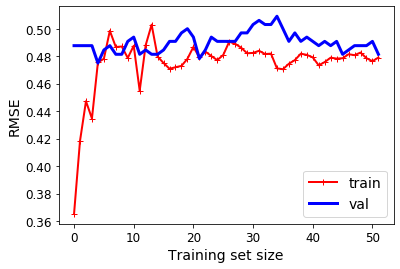

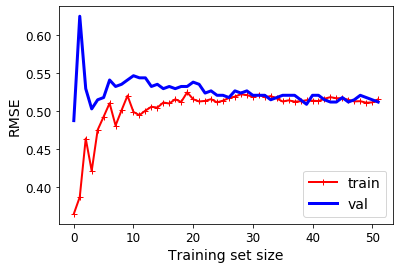

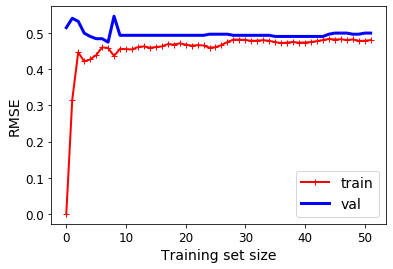

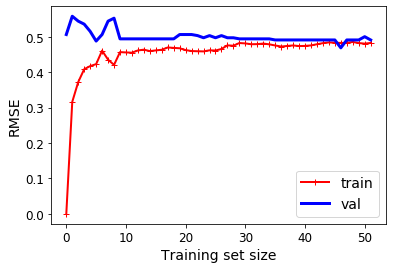

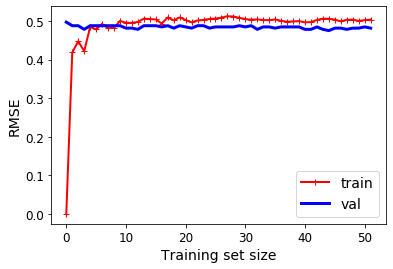

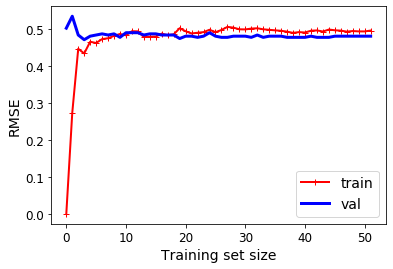

In [23]:
# plot a learning curve for each model
for cl in cls: 
    train_errors, test_errors = [], []
    plt.figure()
    
    for m in range(15, len(X_train), 25):
        cls[cl].fit(X_train_scaled[:m], y_train[:m])
        y_train_predict = cls[cl].predict(X_train_scaled[:m])
        y_test_predict = cls[cl].predict(X_test_scaled)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        test_errors.append(mean_squared_error(y_test, y_test_predict))
    
    print(cl,"learning curve")
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(test_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="lower right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)              